In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

Now Let's import our Dataframe. I used the `pd.DataReader()` library to import my dataframe. It's supper easy and fun :)

In [3]:
import yfinance as yf

In [8]:
# Data Frame did import from google colab. 
# You can upload the data frame on your google drive and mounting the drive with the google clab
df = yf.download('BTC-USD', start='2022-09-15', end='2024-06-10', interval='1h')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-09-15 00:00:00+00:00,20242.289062,20267.703125,20182.068359,20182.068359,20182.068359,1843200
2022-09-15 01:00:00+00:00,20182.166016,20182.166016,20029.976562,20171.447266,20171.447266,216350720
2022-09-15 02:00:00+00:00,20175.007812,20184.330078,20057.339844,20096.835938,20096.835938,0
2022-09-15 03:00:00+00:00,20102.111328,20108.949219,19988.166016,20027.912109,20027.912109,266326016
2022-09-15 04:00:00+00:00,20030.917969,20081.582031,19996.945312,20049.201172,20049.201172,219176960


In [9]:
# Checking the shape of our original data frame
df.shape

(15132, 6)

### Now let's plot our close price only. We wanna use the **dailty close price** of Bitcoin for our model in this notebook so we only plot **close price**

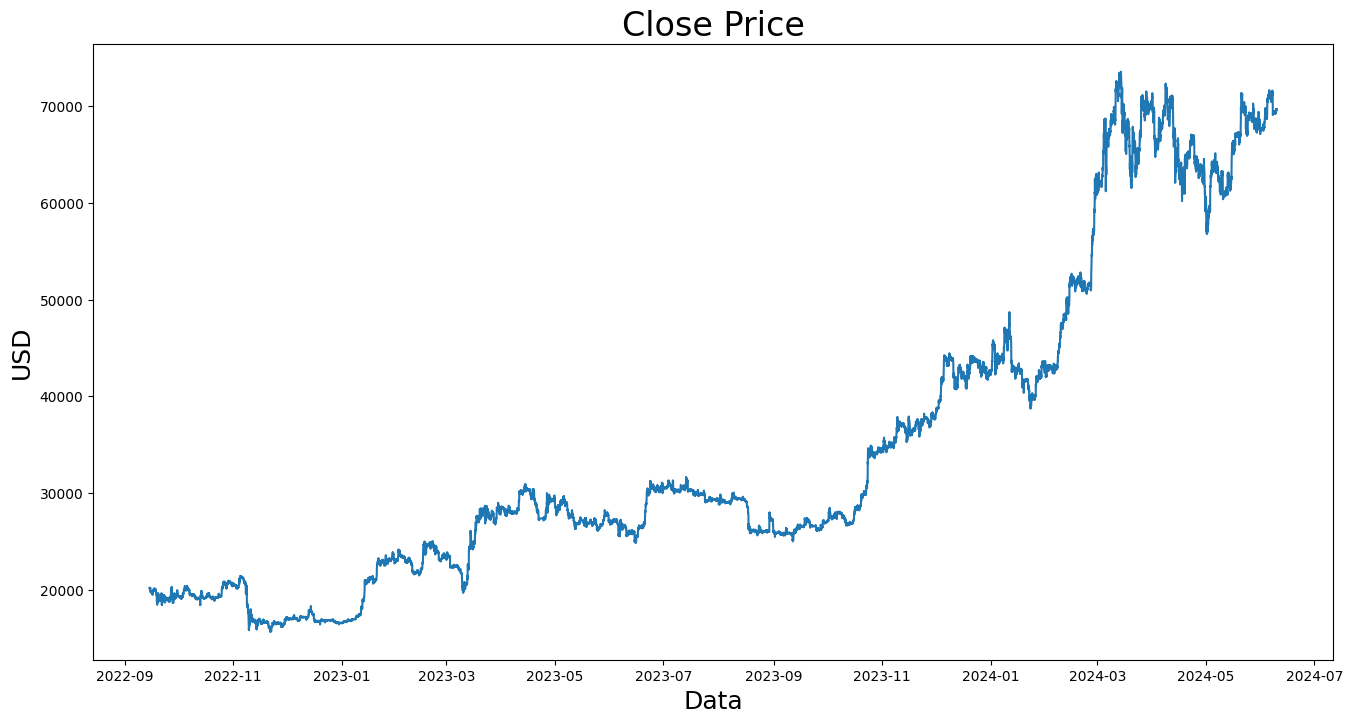

In [10]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

### So as we want to work only with Close Price, let's use `.filter` methode.
### Then we will import the values of the close price column in `data` variable to `dataset` variable.

In [11]:
#Creat a new dataframe with only Close Price
data = df.filter(['Close'])
#Convert the dataframe to numpy array
dataset = data.values
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len

12106

### Now that we have our close price values in a seprated dataframe we can start normalization our data.

In [12]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.07819674],
       [0.07801337],
       [0.07672521],
       ...,
       [0.93356679],
       [0.93159037],
       [0.93214676]])

### In this case, we can't use `train_test_split` function, because we need our train and test sets to be **Sequential Data**. LSTM network needs to have the *last output values* of network layer for the *input of the next layer* of network. So we can't use `train_test_split` and randomize our train/test data.

Our model will predict the price by looking the last 60 days of price. this will help our model to predict a better price and not just a random number that would have less than %50 accuracy. 

In [13]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into X_train and y_train data sets
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])


  if i <= 60:
    print(X_train)
    print(y_train)
    print()

[array([0.07819674, 0.07801337, 0.07672521, 0.07553525, 0.0759028 ,
       0.07736755, 0.07677856, 0.07838557, 0.07771811, 0.07741449,
       0.07753362, 0.07804847, 0.07753261, 0.07710123, 0.07052338,
       0.07062049, 0.0724385 , 0.07217254, 0.07120392, 0.07175573,
       0.07215973, 0.07225445, 0.06971631, 0.06979852, 0.07126368,
       0.07046329, 0.07084244, 0.07090752, 0.07216445, 0.07108789,
       0.07112559, 0.07072917, 0.06985979, 0.07111473, 0.07169719,
       0.07281977, 0.07007726, 0.0677667 , 0.06982523, 0.06914492,
       0.06713899, 0.06582828, 0.06736424, 0.06842202, 0.07050878,
       0.07065351, 0.07047047, 0.07111261, 0.07430965, 0.07510251,
       0.07350312, 0.07329972, 0.07410186, 0.07262157, 0.07226912,
       0.07253983, 0.07301006, 0.07310333, 0.07275496, 0.072192  ])]
[0.07279596834209157]



In [14]:
len(X_train)

12046

### So now X_train has 12046 array which any of them contains 60 days of price in them and y_train contains 12046 days of price which is the price of the last 60 hours.

### LSTM model needs the data to be an *array*. So here we will convert X_train and y_train to an array list.

In [15]:
# Convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [16]:
X_train.shape

(12046, 60)

### LSTM needs the data to be inputet by 3 dimension. So we will reshape X_train to a 3-dim array

In [17]:
# Reshape the data because LSTM needs 3 dim
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # we make it like pros. it wanna say "np.reshape(X_train, (2083, 60, 1))"
X_train.shape

(12046, 60, 1)

### Now that we finish creating our train data, we can create our *test data* (Just like how we did with train data).

In [18]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
test_data = scaled_data[training_data_len - 60 : , :]

#Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])


In [19]:
# Convert the data to a numpy array 
X_test = np.array(X_test)

In [20]:
# Reshape the test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### **Creating the model**

### We are using 2 layers of LSTM and 2 layers of Dense. Our first LSTM layer has `return_sequence=True` because our first and second layers are LSTM and we have to pass the output of the first layer to the second layer. (Again: **LSTM is a Network for Sequential Data**) 

Our last layer only has one unit in it while we need only one number (one price) to predict.

In [21]:
# Build LSTM model
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) , the simple form is "input_shape(60, 1)""
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))

2024-07-14 13:04:25.684598: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-14 13:04:25.684722: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-14 13:04:25.684734: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-14 13:04:25.685294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-14 13:04:25.685952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')

### We will store the steps of each epochs in `history` variable. We are doing this to ploting the loss and finding the best number of epochs to avoid overfiting training.

### Here we make a variable call `callback` which has the job to stop training the model whenever the *loss* is no longer decreasing.

(for more detail check the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) library)

In [23]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10


2024-07-14 13:04:41.845188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12046/12046 [==============================] - 149s 12ms/step - loss: 1.4981e-04
Epoch 2/10
12046/12046 [==============================] - 141s 12ms/step - loss: 5.1453e-05
Epoch 3/10
12046/12046 [==============================] - 142s 12ms/step - loss: 3.1487e-05
Epoch 4/10
12046/12046 [==============================] - 144s 12ms/step - loss: 2.6980e-05
Epoch 5/10
12046/12046 [==============================] - 142s 12ms/step - loss: 2.4311e-05
Epoch 6/10
12046/12046 [==============================] - 141s 12ms/step - loss: 2.3739e-05
Epoch 7/10
12046/12046 [==============================] - 141s 12ms/step - loss: 2.2748e-05
Epoch 8/10
12046/12046 [==============================] - 138s 11ms/step - loss: 1.9981e-05
Epoch 9/10
12046/12046 [==============================] - 150s 12ms/step - loss: 2.0060e-05
Epoch 10/10
12046/12046 [==============================] - 140s 12ms/step - loss: 1.8079e-05


In [24]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
len(predictions_1)

95/95 [==============================] - 3s 13ms/step


3026

In [25]:
# Get the root mean squared error (RMSE) for model_1
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse

3604.9494911289657

Text(0.5, 0, 'epochs')

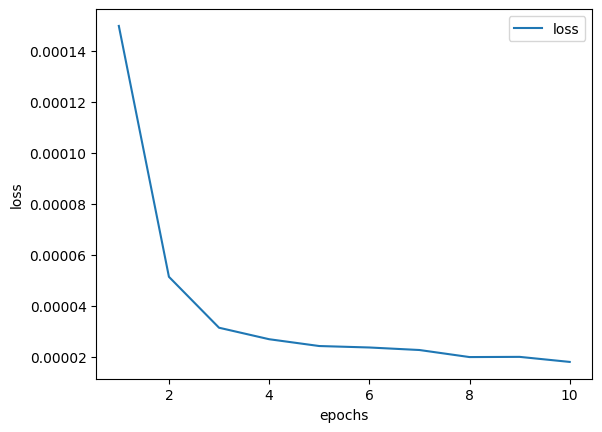

In [26]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

### As we can see, on epochs 6 and 10 we have the less loss and best scores. So we can train our model again with 6 epochs to see which one is better fiting.

/var/folders/sp/kvftqjhx2zjd2vbyln_k7zg00000gn/T/ipykernel_54578/3649973803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1


"plt.subplot(2, 1, 2)\nplt.title('Model_2 with 6 epochs')\nplt.xlabel('Data', fontsize=18)\nplt.ylabel('Close Price USD', fontsize=18)\nplt.plot(train['Close'])\nplt.plot(valid_2[['Close', 'Predictions']])\n\nplt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')\n\nplt.subplots_adjust(left=0.1,\n                    bottom=0.1, \n                    right=0.9, \n                    top=1, \n                    wspace=0.4, \n                    hspace=0.4)\nplt.show()"

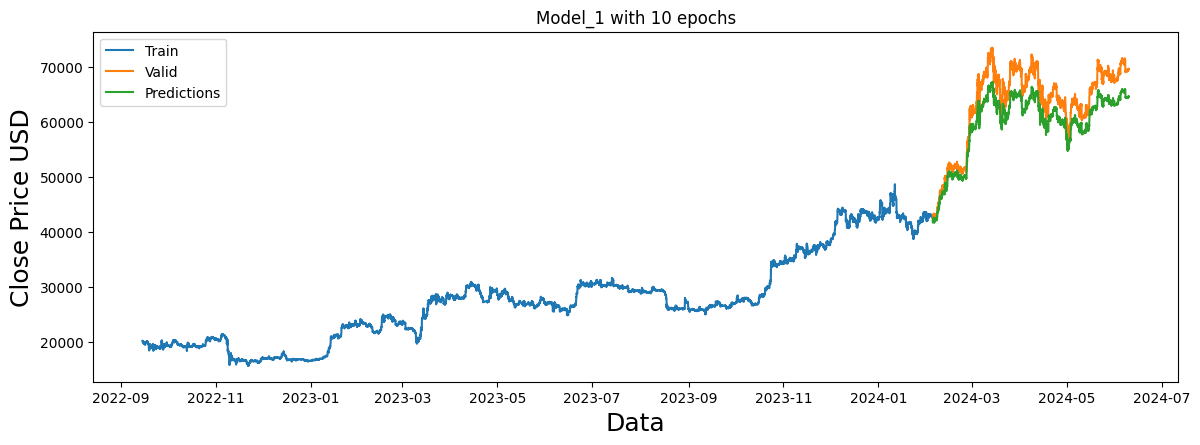

In [27]:
# Plot the data
train = data[:training_data_len]

#data for model_1
valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1

# Visualized the data 
#model_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

It seem's our model_1 has a better predictions than the model_2. So please keep in mind that never choose a model to use, without ploting the result ;)

### Now it's time to predict a future day price which is not in train or test set. In other words we want to predict a price out of the dataframe which is the price of today. 

### So first we need to create a new variable `last_60_days` and use it to predict the today price of Bitcoin. This way we can create a new test set to creating the price of last 60 days from today (today is 1/15/2022).

In [28]:
#Get the last 60 day closing price values and convert the datadrame to an array
last_60_days = data[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
# create an empty list
new_X_test = []
# Append the past 60 days
new_X_test.append(last_60_days_scaled)
# Convert the X_test data set to a numpy array
new_X_test = np.array(new_X_test)
# Reshape the data 
new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model_1.predict(new_X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 422ms/step
[[69634.414]]


![Example](/Users/suneet/Downloads/Proofs/Bitcoin_price_prediction/example.png)


It seems our model did a good job with predicting the price just after 10th june EOD, i.e Open of 11th june price. We might upgrade this model in the future together.

The model can improve the model that we write together by doing these steps:

* Increase or decrease the hidden layers
* Increase or decrease the Units per each layer
* Using other types of layer or changing the activation function of the layers
* Train more the model with diffrent batch size and see what will happen